## Setup

N.B. Based on an [OpenAI example notebook](https://github.com/openai/openai-cookbook/blob/main/examples/How_to_finetune_chat_models.ipynb). [gptchem](https://github.com/kjappelbaum/gptchem) uses an outdated version of the OpenAI API.

In [54]:
from typing import Union, List, Dict
import pathlib as pl
import json
import os
from datetime import datetime

import openai
import tiktoken
import pandas as pd
from rdkit import Chem
from sklearn.model_selection import train_test_split

from ai4chem.utils import randomize_smiles
from ai4chem.tokenizers import gpt_num_tokens_from_messages

with open('/Users/azadoks/.zshrc.d/10_openai_bot.sh', 'r') as f:
    api_key = f.read().split('=')[1].strip()

client = openai.OpenAI(api_key=api_key)

In [55]:
train_df = pd.read_json('../data/combined/train.json')
validate_df = pd.read_json('../data/combined/validate.json')
test_df = pd.read_json('../data/combined/test.json')

## Data preparation

In [56]:
def get_system_message(property_name: str) -> str:
    return f"You predict properties of molecules with high accuracy to assist chemists. You are to predict the {property_name} maximum wavelength in nanometers of the provided molecule when dissolved in the provided solvent."

def get_user_message(row, representation: Union[str, List[str]]="SMILES") -> str:
    def _get_molecule_line(row, representation: str) -> str:
        return f"Molecule {representation}: {row[f'CHROMOPHORE_{representation}']}"
    def _get_solvent_line(row, representation: str) -> str:
        return f"Solvent {representation}: {row[f'SOLVENT_{representation}']}"

    if isinstance(representation, str):
        molecule_lines = _get_molecule_line(row, representation)
        solvent_lines = _get_solvent_line(row, representation)
    else:
        molecule_lines = "\n".join([_get_molecule_line(row, rep) for rep in representation])
        solvent_lines = "\n".join([_get_solvent_line(row, rep) for rep in representation])

    return f'{molecule_lines}\n\n{solvent_lines}'

def get_train_conversation(row, property_name: str, representation: Union[str, List[str]]="SMILES") -> Dict:
    messages = []
    messages.append({'role': 'system', 'content': get_system_message(property_name)})
    messages.append({'role': 'user', 'content': get_user_message(row, representation)})
    property_key = f'{property_name.upper()}_MAX_NM'
    messages.append({'role': 'assistant', 'content': f'{int(row[property_key]):4d} nm'})
    return {'messages': messages}

def get_test_conversation(row, property_name: str, representation: Union[str, List[str]]="SMILES") -> Dict:
    messages = []
    messages.append({'role': 'system', 'content': get_system_message(property_name)})
    messages.append({'role': 'user', 'content': get_user_message(row, representation)})
    property_key = f'{property_name.upper()}_MAX_NM'
    return {'messages': messages}, f'{int(row[property_key]):4d} nm'

def get_prompt(row, property_name: str, representation: Union[str, List[str]]="SMILES") -> str:
    return f"The predicted {property_name} maximum wavelength of the molecule {row[f'CHROMOPHORE_{representation}']} when dissolved in {row[f'SOLVENT_{representation}']} is:"

def get_completion(row, property_name: str) -> str:
    property_key = f'{property_name.upper()}_MAX_NM'
    return f'{int(row[property_key]):4d} nm'

def get_train_prompt_response(row, property_name: str, representation: Union[str, List[str]]="SMILES") -> Dict:
    return {
        'prompt': get_prompt(row, property_name, representation),
        'completion': get_completion(row, property_name)
    }

def write_jsonl(data: list, filename: os.PathLike) -> None:
    with open(filename, 'w') as f:
        for item in data:
            f.write(json.dumps(item) + '\n')

def count_tokens(data: List[Dict]) -> int:
    return sum(
        gpt_num_tokens_from_messages(row['messages'], model="gpt-3.5-turbo-0613")
        for row in data
    )

In [66]:
property_name = "emission"
representation = "SMILES"
model_name = "babbage-002"

experiment_name = f'{representation.lower()[:3]}-{property_name[:3].lower()}-{model_name[:1].lower()}{datetime.now().strftime("%d%H%M")}'

if 'gpt' in model_name:
    train_data = train_df.apply(lambda row: get_train_conversation(row, property_name, representation), axis=1).tolist()
    validate_data = validate_df.apply(lambda row: get_train_conversation(row, property_name, representation), axis=1).tolist()
    test_data = test_df.apply(lambda row: get_train_conversation(row, property_name, representation), axis=1).tolist()
elif 'babbage' or 'davinci' in model_name:
    train_data = train_df.apply(lambda row: get_train_prompt_response(row, property_name, representation), axis=1).tolist()
    validate_data = validate_df.apply(lambda row: get_train_prompt_response(row, property_name, representation), axis=1).tolist()
    test_data = test_df.apply(lambda row: get_train_prompt_response(row, property_name, representation), axis=1).tolist()

for conversation in train_data[:5]:
    print(conversation)

{'prompt': 'The predicted emission maximum wavelength of the molecule CC1=C(C(C)(C)C)C(C)=[N+]2C1=C(C)c1c(C)c(C(C)(C)C)c(C)n1[B-]2(F)F when dissolved in CCC(C)C is:', 'completion': ' 569 nm'}
{'prompt': 'The predicted emission maximum wavelength of the molecule COc1ccc2nn(C)c(-c3ccc(C(C)=O)o3)c2c1 when dissolved in CC#N is:', 'completion': ' 458 nm'}
{'prompt': 'The predicted emission maximum wavelength of the molecule CCCCN(CCCC)c1ccc(C#Cc2cc(C#Cc3ccc([N+](=O)[O-])cc3)c(C#Cc3ccc([N+](=O)[O-])cc3)cc2C#Cc2ccc(N(CCCC)CCCC)cc2)cc1 when dissolved in ClCCl is:', 'completion': ' 563 nm'}
{'prompt': 'The predicted emission maximum wavelength of the molecule Cc1cc(/C=C/c2ccccc2Oc2ccc(F)cc2)n2c1C=C1C=CC=[N+]1[B-]2(F)F when dissolved in CS(C)=O is:', 'completion': ' 574 nm'}
{'prompt': 'The predicted emission maximum wavelength of the molecule CN(C)c1ccc(/C=C/c2ccccn2)cc1 when dissolved in O is:', 'completion': ' 512 nm'}


In [67]:
experiment_data_path = pl.Path(f'../data/{experiment_name}')
experiment_data_path.mkdir(exist_ok=True)

train_filename = str(experiment_data_path / "train.jsonl")
write_jsonl(train_data, train_filename)

validate_filename = str(experiment_data_path / "validate.jsonl")
write_jsonl(validate_data, validate_filename)

test_filename = str(experiment_data_path / "test.jsonl")
write_jsonl(test_data, test_filename)

!head -n 5 $train_filename
!wc -l $train_filename
!wc -l $validate_filename
!wc -l $test_filename

{"prompt": "The predicted emission maximum wavelength of the molecule CC1=C(C(C)(C)C)C(C)=[N+]2C1=C(C)c1c(C)c(C(C)(C)C)c(C)n1[B-]2(F)F when dissolved in CCC(C)C is:", "completion": " 569 nm"}
{"prompt": "The predicted emission maximum wavelength of the molecule COc1ccc2nn(C)c(-c3ccc(C(C)=O)o3)c2c1 when dissolved in CC#N is:", "completion": " 458 nm"}
{"prompt": "The predicted emission maximum wavelength of the molecule CCCCN(CCCC)c1ccc(C#Cc2cc(C#Cc3ccc([N+](=O)[O-])cc3)c(C#Cc3ccc([N+](=O)[O-])cc3)cc2C#Cc2ccc(N(CCCC)CCCC)cc2)cc1 when dissolved in ClCCl is:", "completion": " 563 nm"}
{"prompt": "The predicted emission maximum wavelength of the molecule Cc1cc(/C=C/c2ccccc2Oc2ccc(F)cc2)n2c1C=C1C=CC=[N+]1[B-]2(F)F when dissolved in CS(C)=O is:", "completion": " 574 nm"}
{"prompt": "The predicted emission maximum wavelength of the molecule CN(C)c1ccc(/C=C/c2ccccn2)cc1 when dissolved in O is:", "completion": " 512 nm"}
    5000 ../data/smi-emi-b231214/train.jsonl
     100 ../data/smi-emi-b231

In [68]:
with open(train_filename, "rb") as train_fd:
    training_response = client.files.create(
        file=train_fd, purpose="fine-tune"
    )

train_file_id = training_response.id

with open(validate_filename, "rb") as validate_fd:
    validate_response = client.files.create(
        file=validate_fd, purpose="fine-tune"
    )
validate_file_id = validate_response.id

print(experiment_name)
print("Training file ID:", train_file_id)
print("Validation file ID:", validate_file_id)

smi-emi-b231214
Training file ID: file-byylEQQbHdtnsEcLFsV5QMYr
Validation file ID: file-avQ48DibtbXQ4ZEhWQC59tSF


In [69]:
response = client.fine_tuning.jobs.create(
    training_file=train_file_id,
    validation_file=validate_file_id,
    model="babbage-002",
    suffix=experiment_name,
)

job_id = response.id

print("Job ID:", response.id)
print("Status:", response.status)

with open(experiment_data_path / "job_id.txt", "w") as f:
    f.write(job_id)

Job ID: ftjob-Qp2A5vkwnDgK7ZoFUYECKyIn
Status: validating_files


In [83]:
job_id = 'ftjob-0sD9NY99LC8vYePvLgRilYPk'

response = client.fine_tuning.jobs.retrieve(job_id)
fine_tuned_model_id = response.fine_tuned_model

if fine_tuned_model_id is None:
    raise RuntimeError("Fine-tuned model ID not found. Your job has likely not been completed yet.")

print("Fine-tuned model ID:", fine_tuned_model_id)

Fine-tuned model ID: ft:gpt-3.5-turbo-0125:epfl:smi-emis-5k:9RlM7F0y


In [99]:
sum(
    num_tokens_from_messages(get_validate_converation(row, property_name, representation)[0]['messages'], model="gpt-3.5-turbo-0613")
    for (i, row) in validate_df[:500].iterrows()
)

50877

In [100]:
y = []
yhat = []
for (i, row) in validate_df.iloc[:500].iterrows():
    messages, expected = get_validate_converation(row, property_name, representation)
    response = client.chat.completions.create(
        model=fine_tuned_model_id,
        messages=messages['messages'],
        temperature=0,
        max_tokens=12
    )
    content = response.choices[0].message.content
    print(expected, content)
    y.append(int(expected.strip().split()[0]))
    yhat.append(int(content.strip().split()[0]))

with open('smi-emis-gpt-3.5-turbo-0125-5k.json', 'w') as f:
    json.dump({'y': y, 'yhat': yhat}, f)

 515 nm  500 nm
 684 nm  641 nm
 451 nm  418 nm
 444 nm  410 nm
 497 nm  670 nm
 514 nm  545 nm
 393 nm  380 nm
 488 nm  582 nm
 534 nm  450 nm
 572 nm  530 nm
 594 nm  581 nm
 765 nm  670 nm
 508 nm  480 nm
 397 nm  405 nm
 551 nm  570 nm
 469 nm  420 nm
 345 nm  412 nm
 512 nm  620 nm
 436 nm  576 nm
 414 nm  456 nm
 557 nm  570 nm
 432 nm  450 nm
 595 nm  573 nm
 549 nm  564 nm
 415 nm  420 nm
 426 nm  472 nm
 532 nm  552 nm
 420 nm  420 nm
 400 nm  456 nm
 415 nm  420 nm
 443 nm  450 nm
 379 nm  380 nm
 461 nm  420 nm
 700 nm  641 nm
 376 nm  388 nm
 468 nm  641 nm
 442 nm  511 nm
 496 nm  451 nm
 411 nm  420 nm
 679 nm  670 nm
 444 nm  420 nm
 479 nm  464 nm
 419 nm  420 nm
 465 nm  349 nm
 409 nm  415 nm
 622 nm  644 nm
 540 nm  578 nm
 381 nm  491 nm
 622 nm  605 nm
 605 nm  552 nm
 519 nm  490 nm
 399 nm  400 nm
 425 nm  450 nm
 470 nm  510 nm
 397 nm  400 nm
 832 nm  581 nm
 552 nm  570 nm
 447 nm  490 nm
 429 nm  450 nm
 465 nm  488 nm
 354 nm  410 nm
 805 nm  641 nm
 517 nm 

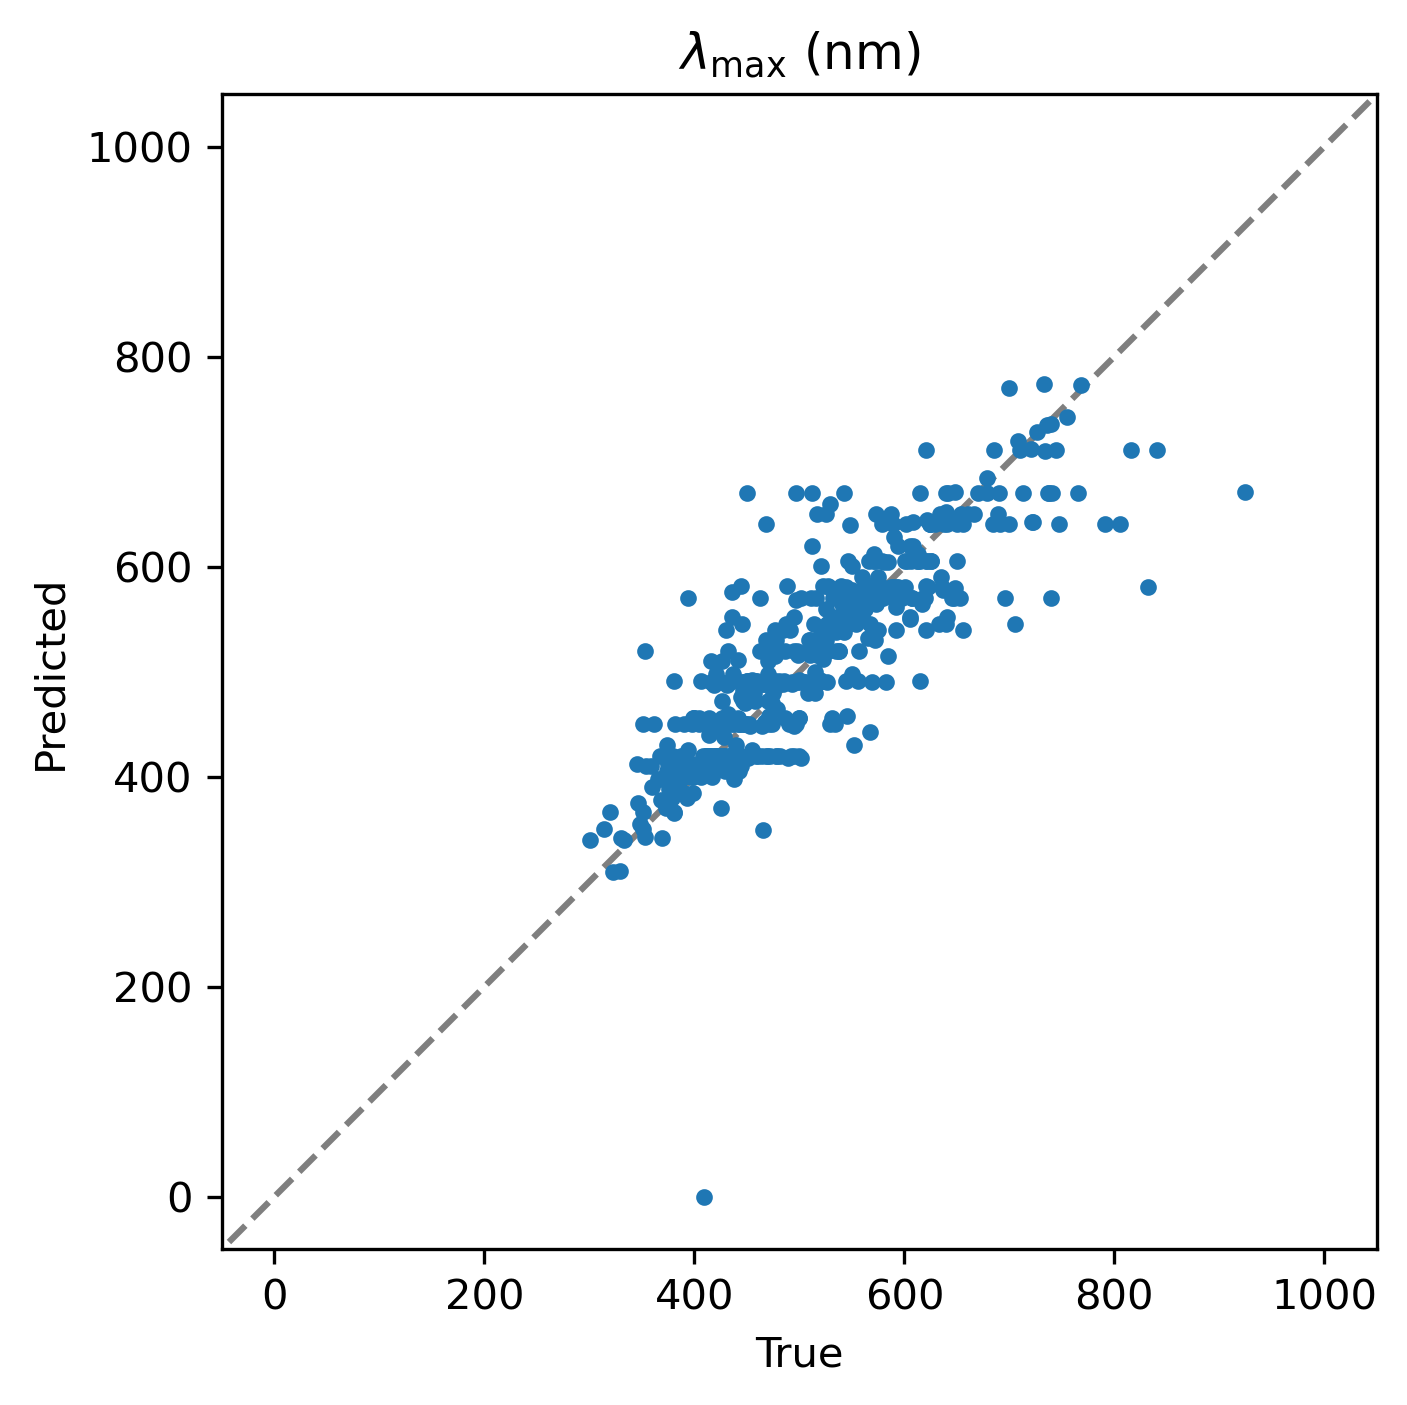

In [146]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=300, figsize=(6,5))

colors = [
    cs_srgb.spec_to_rgb(wavelength_to_spectrum(l))
    for l in yhat
]
ax.plot([-2000, 2000], [-2000, 2000], linestyle='--', color='tab:gray', zorder=0)
ax.scatter(y, yhat, c='tab:blue', marker='.')
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
ax.set_title('$\lambda_{\mathrm{max}}$ (nm)')
ax.set_aspect('equal')
ax.set_xlim(-50, 1050)
ax.set_ylim(-50, 1050)

fig.savefig('smi-emis-gpt-3.5-turbo-0125-5k.png')

In [102]:
import numpy as np
y = np.array(y)
yhat = np.array(yhat)

np.argmin(yhat)

386

In [103]:
yhat[386]

0

In [104]:
validate_df.iloc[386]

SMILES                          Cc1ccc(C(=O)/C=C2\C(=O)Nc3ccccc32)cc1C
SOLVENT_SMILES                                                       O
EMISSION_MAX_NM                                                  409.0
ABSORPTION_MAX_NM                                                338.0
SELFIES              [C][C][=C][C][=C][Branch2][Ring1][=Branch1][C]...
SOLVENT_SELFIES                                                    [O]
INCHI                1S/C18H15NO2/c1-11-7-8-13(9-12(11)2)17(20)10-1...
SOLVENT_INCHI                                              1S/H2O/h1H2
Name: 11282, dtype: object

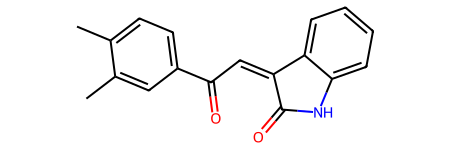

In [106]:
Chem.MolFromSmiles(validate_df.iloc[386]['SMILES'])

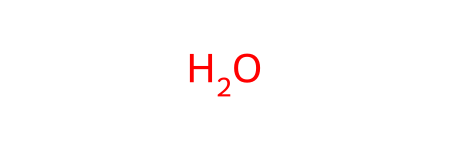

In [107]:
Chem.MolFromSmiles(validate_df.iloc[386]['SOLVENT_SMILES'])

In [131]:
def xyz_from_xy(x, y):
    """Return the vector (x, y, 1-x-y)."""
    return np.array((x, y, 1-x-y))

class ColourSystem:
    """A class representing a colour system.

    A colour system defined by the CIE x, y and z=1-x-y coordinates of
    its three primary illuminants and its "white point".

    TODO: Implement gamma correction

    """

    # The CIE colour matching function for 380 - 780 nm in 5 nm intervals
    cmf = np.loadtxt('cie-cmf.txt', usecols=(1,2,3))

    def __init__(self, red, green, blue, white):
        """Initialise the ColourSystem object.

        Pass vectors (ie NumPy arrays of shape (3,)) for each of the
        red, green, blue  chromaticities and the white illuminant
        defining the colour system.

        """

        # Chromaticities
        self.red, self.green, self.blue = red, green, blue
        self.white = white
        # The chromaticity matrix (rgb -> xyz) and its inverse
        self.M = np.vstack((self.red, self.green, self.blue)).T
        self.MI = np.linalg.inv(self.M)
        # White scaling array
        self.wscale = self.MI.dot(self.white)
        # xyz -> rgb transformation matrix
        self.T = self.MI / self.wscale[:, np.newaxis]

    def xyz_to_rgb(self, xyz, out_fmt=None):
        """Transform from xyz to rgb representation of colour.

        The output rgb components are normalized on their maximum
        value. If xyz is out the rgb gamut, it is desaturated until it
        comes into gamut.

        By default, fractional rgb components are returned; if
        out_fmt='html', the HTML hex string '#rrggbb' is returned.

        """

        rgb = self.T.dot(xyz)
        if np.any(rgb < 0):
            # We're not in the RGB gamut: approximate by desaturating
            w = - np.min(rgb)
            rgb += w
        if not np.all(rgb==0):
            # Normalize the rgb vector
            rgb /= np.max(rgb)

        if out_fmt == 'html':
            return self.rgb_to_hex(rgb)
        return rgb

    def rgb_to_hex(self, rgb):
        """Convert from fractional rgb values to HTML-style hex string."""

        hex_rgb = (255 * rgb).astype(int)
        return '#{:02x}{:02x}{:02x}'.format(*hex_rgb)

    def spec_to_xyz(self, spec):
        """Convert a spectrum to an xyz point.

        The spectrum must be on the same grid of points as the colour-matching
        function, self.cmf: 380-780 nm in 5 nm steps.

        """

        XYZ = np.sum(spec[:, np.newaxis] * self.cmf, axis=0)
        den = np.sum(XYZ)
        if den == 0.:
            return XYZ
        return XYZ / den

    def spec_to_rgb(self, spec, out_fmt=None):
        """Convert a spectrum to an rgb value."""
        if np.all(spec==0):
            # Protect againts zero division
            return np.array((0, 0, 0))
        xyz = self.spec_to_xyz(spec)
        return self.xyz_to_rgb(xyz, out_fmt)

illuminant_D65 = xyz_from_xy(0.3127, 0.3291)

cs_srgb = ColourSystem(red=xyz_from_xy(0.64, 0.33),
                       green=xyz_from_xy(0.30, 0.60),
                       blue=xyz_from_xy(0.15, 0.06),
                       white=illuminant_D65)

def wavelength_to_spectrum(wavelength, intensity=1):
    """Return a spectrum with a single peak at `wavelength`."""
    spectrum = np.zeros((81,))
    idx = (wavelength-380)//5
    if idx < 0 or idx >= 81:
        return spectrum
    spectrum[(wavelength-380)//5] = intensity
    return spectrum